# Depth Space --> Density Space

In [74]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import argopy

In [27]:
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df

In [47]:
reload(ff)
reload(ef)
reload(pf)
reload(df)

<module 'density_funcs' from '/home.ufs/amf2288/argo-intern/density_funcs.py'>

In [48]:
s_ds=xr.open_dataset("202206/202206_lon:(25,45)_lat:(-60,-50).nc")
s = ff.get_ds_interp(s_ds,0,2000,4)
s['SPICE'] = gsw.spiciness0(s.SA,s.CT).rename('SPICE')

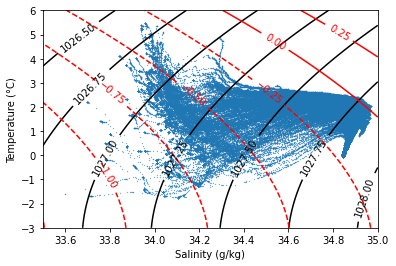

In [49]:
#something is wrong with density here, values look okay except that it should be 26.5-28, not 1026.5-1028
#now that I'm looking, this problem is also present in the function_test notebook, so need to troubleshoot there
#wait it's also in the CCS_poster notebook???? okay I really need to figure this out

ds_li=[s]
Taxis=[-3,6,50]
Saxis=[33.5,35,50]

pf.plot_TS(ds_li, Taxis, Saxis)

In [50]:
rho_grid = np.linspace(26.5,28,1001)

In [51]:
s_rho = df.interpolate2density(s, rho_grid)

50
100
150
200
250
300


In [69]:
import scipy.interpolate as interpolate

def func_var_int(ds, var, rho_grid, flag='group'):
    
    N_PROF_num = ds['N_PROF_NEW'].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', 'N_PROF_NEW'],
                        coords = {'rho_grid': rho_grid, 'N_PROF_NEW': [N_PROF_num]}).rename(var)

In [70]:
def interpolate2density(ds_z):
    
    N_PROF_ind = 0
    pres_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED',rho_grid)
    CT_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SPICE_tilde_xr = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 50)==0:
            print(N_PROF_ind)
        pres_tilde_xr  = xr.concat([pres_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED', rho_grid)], dim='N_PROF_NEW')
        CT_tilde_xr    = xr.concat([CT_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim='N_PROF_NEW')
        SA_tilde_xr    = xr.concat([SA_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim='N_PROF_NEW')
        SIG0_tilde_xr  = xr.concat([SIG0_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim='N_PROF_NEW')
        SPICE_tilde_xr = xr.concat([SPICE_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim='N_PROF_NEW')
    

    ds_rho = xr.merge([pres_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SPICE_tilde_xr])
    
    return ds_rho

In [71]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 10

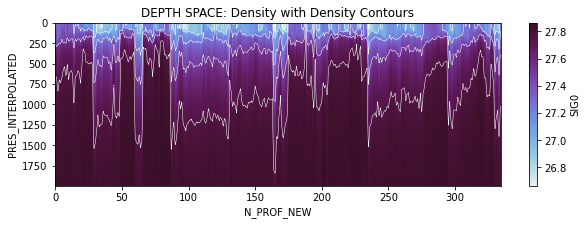

In [75]:
#why is the colorbar y axis switched? that didn't happen with the temperature plot below

plt.figure(figsize=(10,3))
s.SIG0.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',cmap=cmo.dense, rasterized=True)
s.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28], 
                     colors='w', linewidths=0.5)
plt.gca().invert_yaxis()
plt.title('DEPTH SPACE: Density with Density Contours');

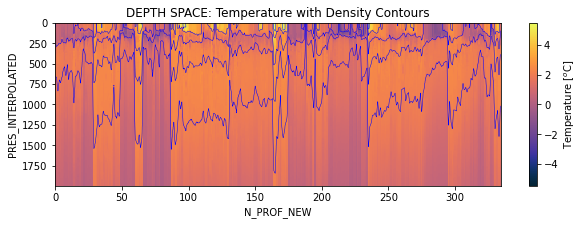

In [77]:
plt.figure(figsize=(10,3))
s.CT.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',
           cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
s.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28], 
                     colors='b', linewidths=0.5)
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED')
plt.xlabel('N_PROF_NEW')
plt.title('DEPTH SPACE: Temperature with Density Contours');

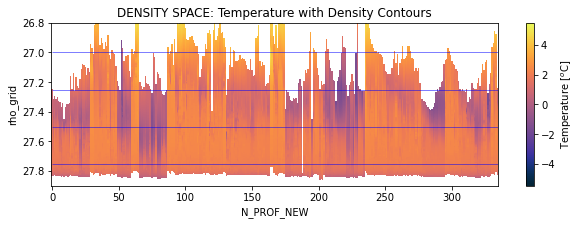

In [78]:
plt.figure(figsize=(10,3))

s_rho.CT.plot(y='rho_grid', x='N_PROF_NEW',
               cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
plt.hlines([26.5,26.75,27,27.25,27.5,27.75,28],0, 350, linewidths=0.5, colors='b')
plt.gca().invert_yaxis()
plt.ylim(27.9,26.8)
plt.title('DENSITY SPACE: Temperature with Density Contours');

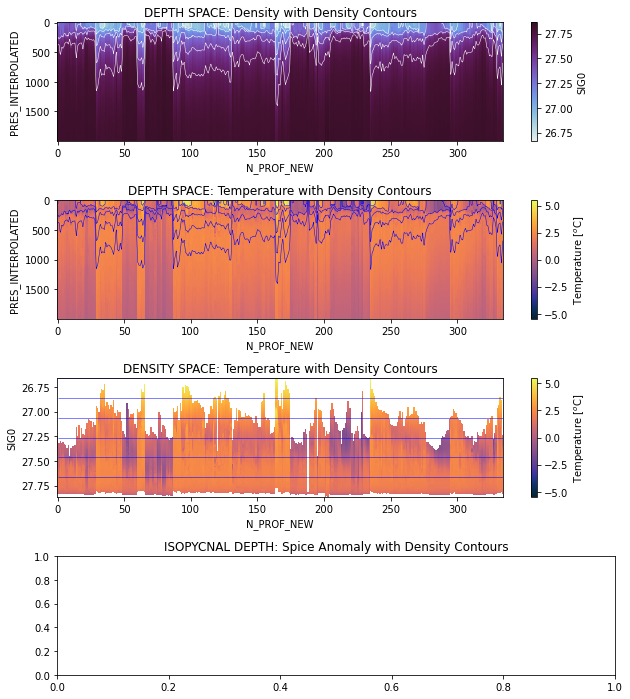

In [52]:
pf.plot_depth_profs(s, s_rho)

In [79]:
def func_var_int_pmean(ds, var, Pmean_smooth): 
    Pmean_grid = np.linspace(0,1000,501)
    
    ds_nonan = ds[var].where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
       
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        
        ds_on_Pmean = f(Pmean_grid)
            
        
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'N_PROF_NEW'],
                        coords = {'Pmean': Pmean_grid, 'N_PROF_NEW': [ds.N_PROF_NEW.values]}).rename(var)

In [80]:
#Pmean  has rho_grid             coordinate
#so_rho has rho_grid, N_PROF_NEW coordinates
#trying to say where

In [83]:
ds = s_rho
N_PROF_NEW_ind=0
Pmean_smooth = s_rho.PRES_INTERPOLATED.mean('N_PROF_NEW').rolling(rho_grid= 80, center=True).mean()

Spice_on_Pmean = func_var_int_pmean(s_rho.isel(N_PROF_NEW=N_PROF_NEW_ind), 'SPICE', Pmean_smooth)

for N_PROF_NEW_ind in range(1, len(ds.N_PROF_NEW)):
    #print(distance_ind)
    if np.mod(N_PROF_NEW_ind, 10)==0:
        print(N_PROF_NEW_ind)
    Spice_on_Pmean = xr.concat([Spice_on_Pmean, func_var_int_pmean(s_rho.isel(N_PROF_NEW=N_PROF_NEW_ind), 'SPICE', Pmean_smooth)]
                              , dim='N_PROF_NEW')

10
20
30


ValueError: `x` must be strictly increasing sequence.

In [82]:
Pmean_smooth = s_rho.PRES_INTERPOLATED.mean('N_PROF_NEW').rolling(rho_grid= 80, center=True).mean()
Pmean_nonan = Pmean_smooth.where(~np.isnan(s_rho['SPICE']) & ~np.isnan(Pmean_smooth), drop=True)

ValueError: Dimensions {'N_PROF_NEW'} do not exist. Expected one or more of ('rho_grid',)

In [ ]:
plt.figure(figsize=(7.5,2.))
Spice_on_Pmean.plot(x='N_PROF_NEW',vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.hlines(Pmean_smooth.sel(rho_grid=[27.1, 27.3, 27.5, 27.7], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='b')
plt.gca().invert_yaxis()

## Load Based on Float Profile

Wanted to take a look at a similar analysis as above, but for one float, with a "distance" axis instead of an "N_PROF" axis (more similar to a glider). I think I found the function Dhruv used to create the distance coordinate, interp_distance pasted below, but it also relies on the `glidertools` package, so I can't complete this unfortunately.

In [61]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
argo_loader

<datafetcher.erddap> 'No access point initialised'
Available access points: float, profile, region
Performances: cache=False, parallel=False
User mode: standard
Dataset: phy

In [63]:
float_IDs = np.unique(s.PLATFORM_NUMBER)

In [64]:
float1 = argo_loader.float(float_IDs[0]).to_xarray()

Text(0, 0.5, 'Longitude')

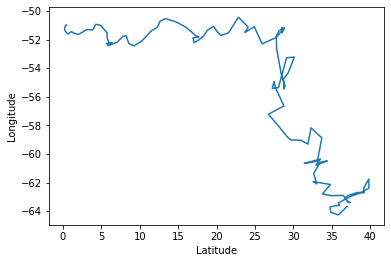

In [66]:
plt.plot(float1.LONGITUDE, float1.LATITUDE)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [67]:
def interp_distance(ds, var, vert_axis = 'PRES_INTERPOLATED'): 

    #print (ds.longitude.mean(vert_axis))
    distance = np.cumsum(gt.utils.distance(ds.LONGITUDE.mean(vert_axis), 
                                           ds.LATITUDE.mean(vert_axis)))
    
    #print(distance)
    dist_grid = np.arange(0, distance.max(), 500)

    for i in range(len(ds[vert_axis])): 
        
        #ds_temp = ds.isel(ctd_pressure=i) # would be nice if this was indexed without the hard coding
         
        #data = ds_temp[var].values
        
        ds_temp = ds[var][i,:]
        data = ds_temp.values
        
        f = interpolate.interp1d(distance, data, fill_value=np.nan)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, vert_axis: ds_temp[vert_axis]}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim=vert_axis)
        
    return da_var_int

In [68]:
test=interp_distance(float1, 'N_PROF')

NameError: name 'gt' is not defined